In [1]:
from scipy import optimize as opt
import matplotlib.pyplot as plt
from os import path
import numpy as np
import cv2 as cv
import os

# Our local modules
import src.calibrate as clb
import src.util as util

# Overview

We refine the distortion coefficients by picking frames from the video where the camera is close to the edges of the field of view (i.e. places where distortion is the most noticeable). To do this, it's best to play the calibration video in VLC and note down the relevant frame indices.

Next, we use these frames to mark curves on the image that are supposed to be straight lines. Once this is done, we optimise the distortion coefficients by trying to make said curves look like straight lines.

# Check that we're in the correct folder

For the code in this notebook to work correctly, the Jupyter server must be started from the `endoscope-calibration` folder. Then you put all of your data in the `./endoscope-calibration/data/`. 

In [2]:
# Check that we're in the right directory
base_dir_name = 'endoscope-calibration'
cwd = os.getcwd()
if not cwd.endswith(base_dir_name):
    print('[WARNING] Your base directory is not \'{}\' - are you running '
          'Jupyter in the correct server?'.format(base_dir_name))
    
data_dir = path.join(cwd, 'data')

# Load relevant frames and define curves

In [3]:
video_name = 'handheld-endoscope-calibration-full.avi'
# frames_to_load = [350, 640, 680, 870, 2450]
frames_to_load = [350, 640, 870, 2450]
all_lines = [
    [ # Frame 350
        [[304, 285, 284, 304, 323, 340, 361],
         [997, 864, 726, 519, 418, 342, 270]],
        [[364, 443, 548, 648, 735, 847, 930, 995],
         [269, 247, 219, 201, 183, 177, 180, 182]],
        [[996, 1018, 1060, 1114, 1151, 1179, 1202, 1216],
         [181, 225, 294, 388, 478, 552, 659, 729]],
        [[486, 522, 564, 604, 649, 689, 731, 770, 810, 848],
         [315, 307, 300, 293, 287, 280, 277, 274, 269, 267]],
        [[482, 524, 568, 613, 658, 701, 748, 790, 834, 873],
         [380, 371, 362, 356, 350, 342, 338, 334, 329, 327]],
        [[481, 522, 613, 660, 708, 741, 755, 802, 843, 885, 923],
         [414, 409, 393, 387, 379, 379, 373, 369, 363, 359, 357]],
        [[476, 521, 569, 619, 669, 716, 765, 811, 858, 901, 939],
         [456, 447, 439, 435, 428, 420, 414, 409, 405, 397, 394]],
        [[474, 522, 571, 622, 674, 726, 775, 824, 872, 915, 956],
         [500, 494, 488, 480, 472, 464, 458, 452, 446, 441, 436]],
        [[472, 521, 572, 627, 681, 734, 788, 838, 884, 930, 971],
         [548, 544, 535, 528, 522, 513, 508, 498, 493, 485, 480]],
        [[474, 524, 577, 631, 687, 743, 797, 850, 898, 946],
         [600, 594, 590, 581, 576, 567, 561, 551, 543, 535]],
        [[524, 523, 523, 523, 520, 521, 523, 523, 524],
         [307, 334, 371, 407, 448, 493, 544, 594, 649]],
        [[524, 579, 638, 693, 751, 806, 862, 910, 960, 1001],
         [650, 646, 638, 631, 623, 615, 604, 594, 584, 576]],
        [[862, 849, 838, 825, 811, 796, 785, 770],
         [603, 550, 500, 452, 406, 357, 313, 271]],
        [[647, 652, 655, 660, 664, 669, 675, 680, 685, 689, 693],
         [285, 311, 337, 370, 400, 432, 480, 518, 547, 582, 618]],
    ],
    [ # Frame 640
        [[243, 297, 368, 460, 520, 613, 703, 783, 833],
         [359, 349, 338, 328, 320, 316, 313, 314, 317]],
        [[833, 851, 873, 893, 912, 942, 967, 985, 998, 1007],
         [317, 358, 413, 453, 517, 604, 691, 773, 830, 918]],
        [[194, 225, 264, 292, 345, 372, 429, 468, 527, 569],
         [457, 456, 452, 448, 442, 441, 437, 434, 429, 425]],
        [[185, 203, 238, 269, 313, 351, 398, 449, 492, 538, 589, 624],
         [494, 492, 490, 487, 485, 482, 478, 474, 471, 466, 467, 462]],
        [[171, 195, 230, 262, 290, 332, 368, 407, 445, 480, 524, 562, 612],
         [535, 533, 533, 531, 529, 527, 525, 523, 521, 517, 516, 513, 510]],
        [[165, 187, 208, 237, 270, 296, 324, 344, 365, 394, 417, 462, 485, 530, 571, 611, 633],
         [579, 578, 578, 577, 578, 577, 576, 574, 574, 573, 572, 570, 569, 567, 564, 561, 559]],
        [[150, 174, 200, 233, 254, 277, 304, 337, 356, 382, 413, 446, 470, 507, 542, 561, 597, 634],
         [625, 626, 627, 628, 629, 630, 630, 629, 628, 628, 628, 629, 625, 624, 622, 622, 621, 616]],
        [[139, 161, 190, 223, 248, 283, 332, 360, 391, 426, 475, 515, 551, 590, 628],
         [672, 674, 677, 680, 682, 684, 688, 688, 687, 687, 687, 686, 685, 683, 679]],
        [[133, 161, 190, 225, 267, 308, 361, 391, 428, 475, 522, 580, 637],
         [722, 726, 732, 738, 743, 745, 749, 750, 750, 751, 751, 748, 744]],
        [[130, 152, 187, 231, 271, 317, 353, 389, 431, 490, 531, 594, 649],
         [775, 780, 788, 798, 805, 810, 814, 817, 819, 819, 817, 818, 813]],
        [[155, 155, 160, 165, 173, 183, 194, 208, 227],
         [834, 798, 762, 708, 656, 612, 566, 511, 457]],
        [[194, 195, 199, 205, 212, 219, 227, 241, 254, 261],
         [845, 784, 741, 691, 653, 610, 568, 520, 474, 452]],
        [[235, 236, 236, 239, 243, 245, 251, 261, 274, 282, 289, 300],
         [856, 810, 777, 752, 722, 692, 654, 605, 562, 516, 485, 452]],
        [[283, 282, 284, 287, 291, 292, 300, 307, 314, 322, 326, 334, 339],
         [866, 844, 800, 752, 725, 684, 644, 593, 557, 525, 499, 464, 445]],
        [[339, 339, 337, 340, 342, 342, 345, 349, 353, 356, 361, 366, 370, 374, 376, 381],
         [874, 841, 809, 763, 734, 704, 671, 647, 613, 582, 552, 530, 513, 489, 468, 446]],
        [[393, 392, 392, 392, 394, 398, 399, 403, 405, 407, 411, 413, 418, 424, 427],
         [878, 849, 826, 795, 756, 709, 666, 638, 603, 579, 549, 526, 493, 465, 441]],
        [[528, 527, 525, 523, 522, 521, 520, 521, 520, 522, 522, 524],
         [886, 848, 815, 766, 724, 687, 647, 605, 554, 517, 480, 433]],
    ],
#     [ # Frame 680
#         [[182, 314, 499, 634, 702],
#          [306, 259, 218, 201, 194]],
#         [[710, 743, 824, 879, 928, 946],
#          [203, 266, 459, 636, 831, 942]],
#         [[426, 357, 269, 184, 130, 61],
#          [389, 404, 420, 441, 457, 478]],
#         [[419, 353, 290, 206, 148, 98, 49],
#          [444, 459, 469, 488, 497, 511, 523]],
#         [[413, 343, 265, 214, 148, 91, 38],
#          [507, 520, 532, 541, 550, 562, 572]],
#         [[420, 358, 294, 220, 164, 110, 60, 34],
#          [578, 589, 595, 605, 609, 615, 617, 618]],
#         [[410, 306, 216, 115, 65, 34],
#          [659, 669, 675, 678, 675, 675]],
#         [[429, 313, 247, 196, 146, 99, 48, 30],
#          [740, 745, 751, 748, 747, 738, 732, 728]],
#         [[434, 354, 292, 243, 210, 131, 77, 38],
#          [832, 832, 835, 832, 826, 812, 799, 787]],
#         [[374, 367, 365, 359, 359, 358, 363, 374],
#          [378, 436, 492, 536, 609, 683, 797, 903]],
#         [[321, 312, 301, 297, 291, 291, 292, 296, 300],
#          [381, 437, 509, 564, 640, 708, 782, 851, 902]],
#         [[272, 259, 247, 239, 234, 230, 232, 234, 239],
#          [387, 444, 515, 577, 647, 706, 801, 849, 898]],
#         [[227, 213, 201, 192, 182, 178, 177, 178, 181, 186],
#          [401, 457, 506, 567, 635, 705, 764, 812, 840, 881]],
#         [[185, 169, 158, 148, 140, 136, 134, 135, 136, 142],
#          [415, 469, 515, 569, 640, 687, 732, 783, 825, 868]],
#         [[151, 142, 133, 122, 115, 109, 105, 101, 100, 98, 100, 101, 106],
#          [420, 449, 486, 530, 562, 604, 637, 670, 699, 743, 786, 821, 859]],
#         [[115, 104, 95, 81, 77, 72, 69, 68, 69, 69, 72],
#          [439, 479, 522, 579, 622, 654, 695, 721, 753, 790, 829]],
#         [[87, 77, 65, 58, 52, 46, 44, 44],
#          [454, 486, 534, 569, 611, 641, 696, 770]],        
#     ],
    [ # Frame 720
        [[368, 361, 362, 365, 370, 377, 385, 396, 411],
         [981, 917, 823, 729, 653, 597, 530, 462, 406]],
        [[465, 526, 590, 644, 733, 801, 872, 939, 998, 1051, 1101],
         [397, 397, 392, 390, 391, 391, 393, 395, 398, 400, 404]],
        [[654, 715, 778, 829, 881, 924, 971, 1003, 1040, 1066],
         [548, 547, 542, 540, 537, 534, 532, 527, 527, 522]],
        [[663, 726, 788, 844, 896, 943, 987, 1023, 1053, 1084, 1107],
         [609, 607, 602, 598, 591, 586, 580, 574, 568, 566, 563]],
        [[671, 737, 799, 860, 911, 961, 1002, 1038, 1069, 1101, 1124],
         [680, 675, 668, 660, 649, 643, 635, 625, 617, 611, 608]],
        [[702, 771, 840, 902, 956, 1004, 1045, 1082, 1112, 1138, 1162],
         [975, 962, 945, 923, 904, 884, 863, 841, 821, 804, 785]],
        [[692, 763, 833, 894, 952, 1001, 1042, 1081, 1124, 1155],
         [904, 893, 877, 861, 842, 824, 804, 785, 763, 743]],
        [[683, 756, 823, 884, 940, 986, 1030, 1064, 1097, 1140],
         [828, 819, 807, 791, 777, 762, 746, 733, 718, 700]],
        [[674, 746, 814, 870, 926, 978, 1017, 1055, 1086, 1117],
         [752, 745, 735, 725, 713, 699, 690, 678, 668, 656]],
        [[1038, 1053, 1063, 1072, 1081, 1091, 1103, 1111, 1117, 1119],
         [528, 563, 590, 620, 655, 690, 748, 791, 842, 899]],
        [[968, 981, 992, 1006, 1014, 1025, 1032, 1041, 1049, 1052, 1054],
         [535, 568, 602, 651, 687, 722, 762, 815, 874, 916, 957]],
        [[927, 935, 945, 950, 958, 971, 980, 991, 999, 1008, 1010, 1011],
         [535, 557, 583, 608, 643, 686, 728, 781, 839, 897, 956, 986]],
        [[884, 892, 902, 911, 918, 926, 930, 937, 943, 954, 958, 963],
         [542, 572, 606, 643, 675, 710, 739, 769, 808, 881, 935, 996]],
        [[832, 852, 868, 878, 888, 899, 906],
         [545, 632, 702, 754, 818, 884, 958]]
    ],
    [ # Frame 2450
        [[271, 334, 397, 499, 565, 645, 721, 788, 864, 930, 969],
         [288, 250, 217, 169, 145, 119, 99, 89, 78, 73, 74]],
        [[971, 986, 995, 1000, 994, 982, 969, 952, 938, 931],
         [76, 144, 215, 352, 490, 600, 671, 749, 810, 836]],
        [[564, 611, 672, 739, 802, 877, 917],
         [825, 832, 839, 841, 843, 840, 838]],
        [[237, 267, 303, 340, 369, 409, 457, 496, 524, 551],
         [339, 406, 470, 533, 580, 641, 707, 754, 788, 816]],
        [[355, 376, 407, 438, 472, 504, 547, 583, 630, 675],
         [376, 369, 361, 350, 339, 331, 319, 310, 300, 289]],
        [[675, 688, 707, 716, 725, 731, 740, 748],
         [289, 333, 413, 442, 484, 512, 549, 587]],
        [[370, 406, 447, 488, 534, 572, 628, 663, 710, 734],
         [409, 399, 386, 376, 367, 358, 345, 339, 330, 325]],
        [[388, 421, 458, 490, 521, 559, 601, 632, 674, 719, 742],
         [440, 431, 423, 419, 411, 403, 395, 389, 384, 375, 372]],
        [[404, 444, 483, 523, 572, 620, 671, 719, 752],
         [471, 463, 455, 449, 441, 434, 425, 421, 415]],
        [[419, 457, 487, 536, 573, 616, 664, 701, 758],
         [501, 494, 488, 483, 479, 473, 467, 462, 455]],
        [[409, 419, 434, 447, 459, 476, 492, 505, 522],
         [361, 390, 414, 447, 473, 509, 537, 564, 600]],
    ]
]

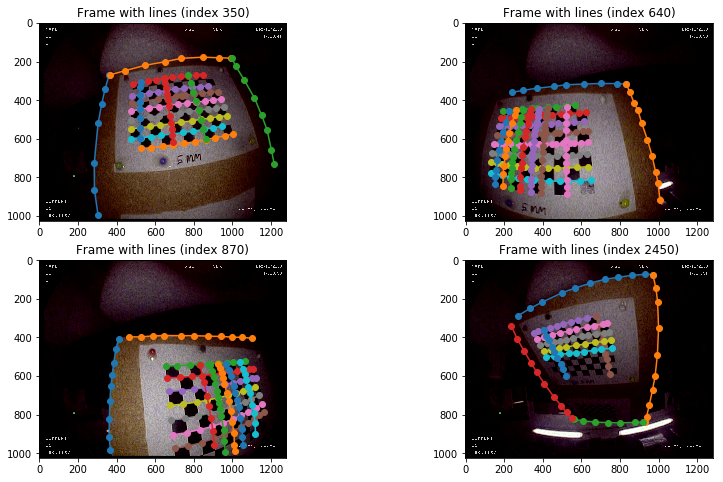

In [4]:
cap = cv.VideoCapture(path.join(data_dir, video_name))
frames = util.pick_frames(cap, frames_to_load, convert_to_rgb=True)
frame_count = len(frames)

curr_i = 0
h, w = frames[0].shape[:2]
nrows = int(np.ceil(frame_count / 2))
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(14, 8))
for frame_i, frame, lines in zip(frames_to_load, frames, all_lines):
    ax = axes[curr_i // 2, curr_i % 2]
    ax.set_title('Frame with lines (index {})'.format(frame_i))
    ax.imshow(frame)
    for line in lines:
        line = np.array(line)
        ax.plot(line[0, :], line[1, :], '-o')
        
    curr_i += 1

# Load previous intrinsics estimates and try to undistort lines

In [5]:
def test_distort_coeffs(cam_matrix, dist_coeffs):
    h, w = frames[0].shape[:2]
    new_cam_matrix, roi = cv.getOptimalNewCameraMatrix(cam_matrix, dist_coeffs,
                                                       (w, h), 1, (w, h))

    for frame_i, frame, lines in zip(frames_to_load, frames, all_lines):
        fixed_frame = cv.undistort(frame, cam_matrix, dist_coeffs,
                                   newCameraMatrix=new_cam_matrix)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
        ax[0].set_title('Frame with lines (index {})'.format(frame_i))
        ax[0].imshow(frame)
        ax[1].set_title('Undistorted frame with lines (index {})'.format(frame_i))
        ax[1].imshow(fixed_frame)

        for line in lines:
            line = np.array(line)
            new_line = util.undistort_line(line, cam_matrix, dist_coeffs, new_cam_matrix)
            ax[0].plot(line[0, :], line[1, :], '-o')
            ax[1].plot(new_line[0, :], new_line[1, :], '-o')

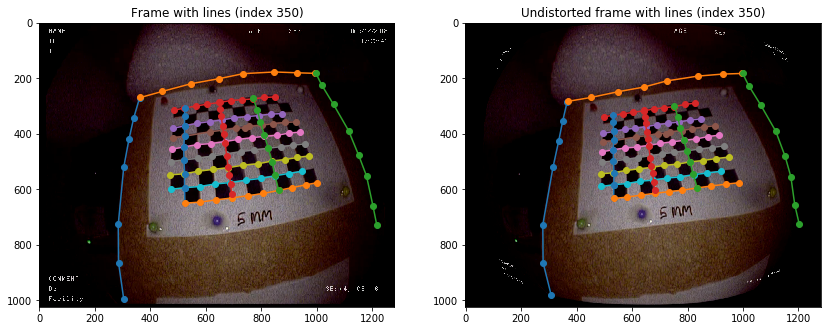

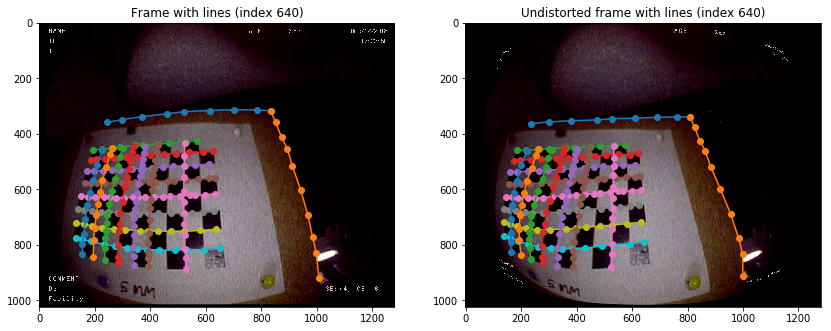

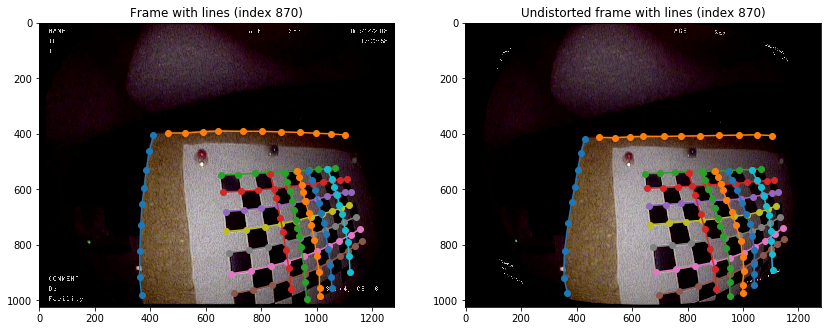

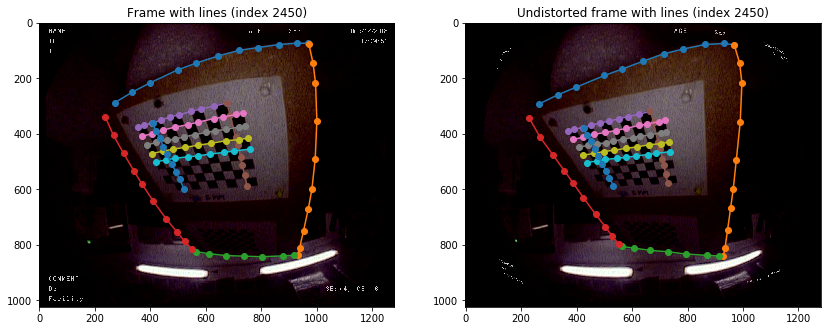

In [6]:
intrinsics_file = path.join(data_dir, 'intrinsics.json')
cam_matrix, dist_coeffs = util.load_intrinsics(intrinsics_file)

test_distort_coeffs(cam_matrix, dist_coeffs)

# Optimize distortion coefficients

In [7]:
# Convert lines into NP array for our convenience
just_lines = []
for frame_lines in all_lines:
    just_lines += frame_lines
just_lines = [np.array(line) for line in just_lines]

def dist(p1, p2):
    """Returns the distance between two points"""
    return np.sqrt(np.sum(np.square(p1 - p2)))

# Define a loss function
def loss(dist_coeffs):
    new_cam_matrix, roi = cv.getOptimalNewCameraMatrix(cam_matrix, dist_coeffs,
                                                       (w, h), 1, (w, h))
    loss_sum = 0
    for old_line in just_lines:
        line = util.undistort_line(old_line, cam_matrix, dist_coeffs, new_cam_matrix)
        point_count = line.shape[1]
        min_dist = dist(line[:, 0], line[:, -1])
        act_dist = 0
        for i in range(point_count - 1):
            act_dist += dist(line[:, i], line[:, i+1])
        norm_factor = min_dist * 100
        loss_sum += (act_dist - min_dist) / norm_factor
        
    return loss_sum
        
new_dist_coeffs = opt.fmin_cg(loss,
                              dist_coeffs,
                              epsilon=1e-6,
                              gtol=1e-15)

print('')
print('Initial loss: {}'.format(loss(dist_coeffs)))
print('Final loss:   {}'.format(loss(new_dist_coeffs)))

         Current function value: 0.000355
         Iterations: 21
         Function evaluations: 899
         Gradient evaluations: 127

Initial loss: 0.0026509377448282923
Final loss:   0.0026509377448282923


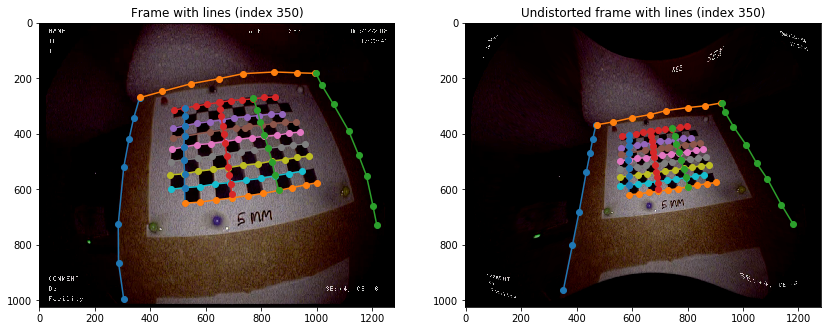

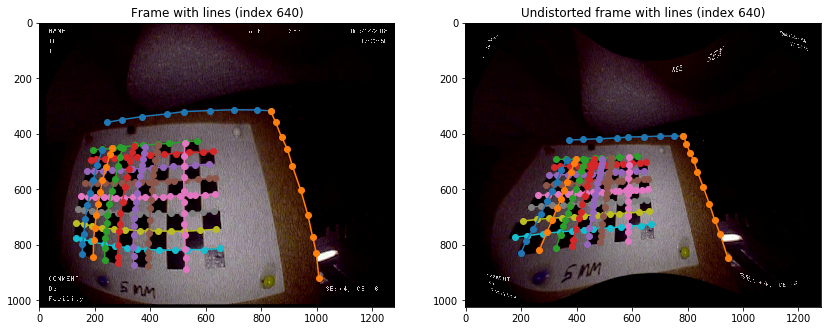

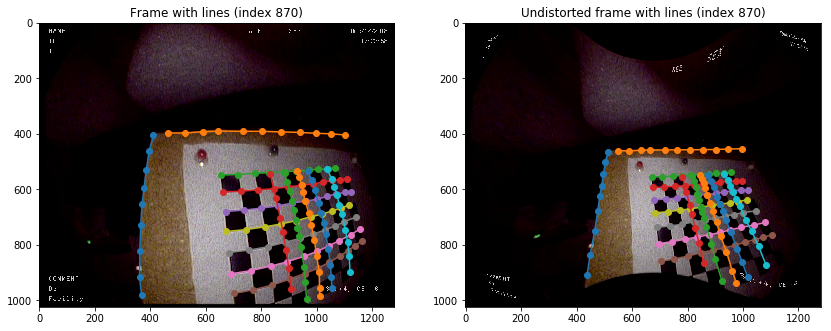

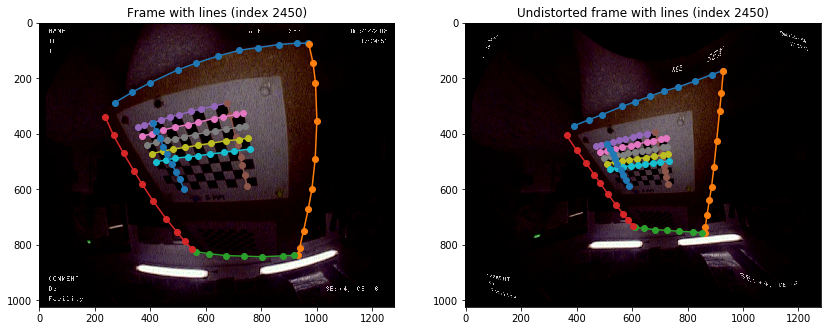

In [8]:
test_distort_coeffs(cam_matrix, new_dist_coeffs)